## The Discrete Voter Model

This notebook tests and runs the subroutines for the **discrete voter model for ecological inference**, including:
1. creating a probabilistic hypercube (PHC): an $\mathbf{R}^n$ array of values, $\omega$, that all sum to $1$
3. given a PHC, a candidate, and a district description, outputting the expectation of votes that candidate received
4. given a PHC, a candidate, a district description, and the observed vote outcomes, outputting the probability of seeing that outcome
5. running a Markov Chain Monte Carlo method on a state space of PHCs
6. visualizing PHCs
7. creating objects to represent real and mock elections

In [1]:
import numpy as np
import pickle
import pymc3 as pm
import tensorflow as tf
from tqdm.autonotebook import trange, tqdm

/Users/hakeemangulu/.local/share/virtualenvs/code-9G5VMzgS/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """


In [2]:
# Import written packages

import dvm
import dvm_eval
import dvm_plot
import elect
import expec_votes as ev
import kings_ei as kei
import phc
import prob_votes as pv
import tools

%matplotlib inline

In [3]:
%load_ext line_profiler

### create a PHC

In [4]:
test_phc = phc.make_phc(3, 10)

### `expec_votes`
Given a PHC, a candidate, and a district description, output the expectation of votes that candidate received.

In [5]:
test_demo = {"Black": 10, "white": 8, "Latinx": 5}

In [6]:
ev.expec_votes(test_phc, test_demo)

<tf.Tensor: shape=(), dtype=float32, numpy=10.39081>

In [8]:
ev.prob_from_expec(test_phc, test_demo, 100000)

<tf.Tensor: shape=(), dtype=float32, numpy=-11.512832>

### `prob_votes`
Given a PHC, a candidate, a district description, and the observed vote outcomes, output the probability of seeing that outcome.

In [7]:
test_observed = 10

In [24]:
test_demo_adv = {'C100': {'Black': 10, 'white': 8, 'Latinx': 5},
                 'C200': {'Black': 5, 'white': 8, 'Latinx': 15}}
test_observed_adv = {'C100': 10,
                     'C200': 2}

In [9]:
test_coeff_dict_adv = pv.get_coefficients(test_demo_adv, test_observed_adv)

In [10]:
test_coeff_dict = test_coeff_dict_adv['C100']

In [11]:
pv.prob_votes(test_phc, test_demo, test_observed, test_coeff_dict)

<tf.Tensor: shape=(), dtype=float32, numpy=-3.1872637>

In [12]:
test_num_trials = 25
bounds_error_count = 0
for _ in trange(test_num_trials):
    log_prob = pv.prob_votes(phc.make_phc(3, 10), 
                             test_demo, test_observed, test_coeff_dict)
    x = tf.math.exp(log_prob)
    if x > 1 or x < 0:
        bounds_error_count += 1
        print(f"Probability out of bounds at {x}")
if bounds_error_count == 0:
    print(f"No bounds errors in {test_num_trials} trials")
else:
    print(f"There were {bounds_error_count} bounds errors")


No bounds errors in 25 trials


### `mcmc`
Run Markov Chain Monte Carlo methods on the state space of PHCs.

In [163]:
rwm_prob_test = dvm.rwm(
    20, 0.2, 
    test_phc,
    test_demo_adv, test_observed_adv, expec_scoring=False)

The Random Walk Metropolis chain will be run in 2 chunks of size 10, with 0 steps at the end.

[1/4] Creating the binomial coefficients...
[2/4] Running the chain on 2 chunks of 10 iterations each...



[3/4] Running the chain for 0 more steps...
[4/4] Burning 0.2 of the sample...
Done.
Generated a sample of 16 observations in ~54 seconds.


In [158]:
rwm_expec_test = dvm.rwm(
    20, 0.2, 
    test_phc,
    test_demo_adv, test_observed_adv, expec_scoring=True)

The Random Walk Metropolis chain will be run in 2 chunks of size 10, with 0 steps at the end.

[1/3] Running the chain on 2 chunks of 10 iterations each...



[2/3] Running the chain for 0 more steps...
[3/3] Burning 0.2 of the sample...
Done.
Generated a sample of 16 observations in ~4 seconds.


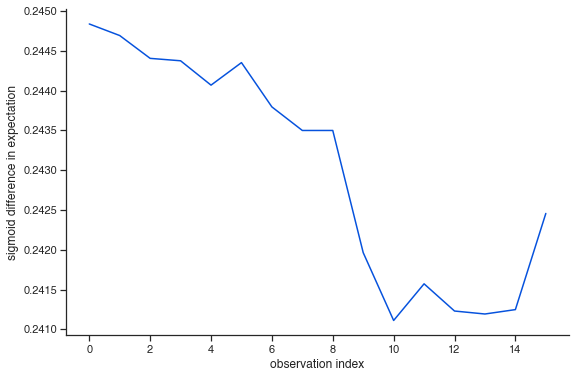

In [159]:
dvm_plot.trace_plot(rwm_expec_test)

In [74]:
# with open('pickles/long_rwm_run.pickle', 'wb') as f:
#     pickle.dump(rwm_test_chain_results, f)

In [168]:
with open('pickles/long_rwm_run.pickle', 'rb') as f:
    long_rwm_run = pickle.load(f)

In [15]:
rwm_test_chain_results = dvm.rwm(
    2000, 0.4, 
    test_phc,
    test_demo, test_observed, expec_scoring=True)

The Random Walk Metropolis chain will be run in 200 chunks of size 10, with 0 steps at the end.

[1/3] Running the chain on 200 chunks of 10 iterations each...



[2/3] Running the chain for 0 more steps...
[3/3] Burning 0.4 of the sample...
Done.
Generated a sample of 1200 observations in ~154 seconds.


In [85]:
hmc_test_chain_results = dvm.hmc(
    20, 0.4, 
    test_phc,
    test_demo, test_observed, expec_scoring=True)

This Hamiltonian Monte Carlo chain will be run in 1 chunks of size 10, with 4 steps of adaptation and 6 steps at the end.

[1/3] Running the chain for 4 steps to adapt the step size...
[2/3] Running the chain with a step size of 0.028829410672187805 on 1 chunks of 10 iterations each...



[3/3] Running the chain for 6 more steps...
[4/3] Burning 0.4 of samples...
Done.
Generated a sample of 12 observations in ~9 seconds.


In [160]:
test_hmc_expec = dvm.hmc(
    20, 0.4, 
    test_phc,
    test_demo_adv, test_observed_adv, expec_scoring=True)

This Hamiltonian Monte Carlo chain will be run in 1 chunks of size 10, with 4 steps of adaptation and 6 steps at the end.

[1/3] Running the chain for 4 steps to adapt the step size...
[2/3] Running the chain with a step size of 0.03060299903154373 on 1 chunks of 10 iterations each...



[3/3] Running the chain for 6 more steps...
[4/3] Burning 0.4 of samples...
Done.
Generated a sample of 12 observations in ~21 seconds.


In [24]:
test_mle_phc = dvm.chain_mle(rwm_test_chain_results)

(<tf.Tensor: shape=(10, 10, 10), dtype=float32, numpy=
 array([[[9.88422660e-04, 1.15218491e-03, 9.20347986e-04, 9.58665798e-04,
          1.44662161e-03, 6.51828013e-04, 1.14762131e-03, 9.78542026e-04,
          6.40899525e-04, 8.50521319e-04],
         [1.24532334e-03, 3.41719599e-04, 7.11536326e-04, 7.06176739e-04,
          1.58133334e-03, 8.82444670e-04, 1.49193720e-05, 1.55672838e-03,
          1.24923757e-03, 1.10236905e-03],
         [1.14872318e-03, 1.07252225e-03, 1.22655451e-03, 9.21926170e-04,
          7.12453097e-04, 1.13779155e-03, 1.46079471e-03, 8.47584743e-04,
          1.73499703e-03, 7.31065578e-04],
         [8.33690108e-04, 1.30786747e-03, 1.11900375e-03, 8.35789600e-04,
          1.01799692e-03, 8.13127670e-04, 5.07716322e-04, 9.62811813e-04,
          5.58456639e-04, 1.09260564e-03],
         [8.94862285e-04, 1.18587364e-03, 1.05298625e-03, 9.51616501e-04,
          9.77792195e-04, 7.26343598e-04, 8.30596546e-04, 1.21419493e-03,
          1.13306020e-03, 1.01332

In [25]:
test_mean_phc = dvm.mean_phc(rwm_test_chain_results)

<tf.Tensor: shape=(10, 10, 10), dtype=float32, numpy=
array([[[9.5325988e-04, 1.1362870e-03, 1.0862580e-03, 1.0762101e-03,
         1.4710519e-03, 8.2694931e-04, 1.0856546e-03, 9.5726032e-04,
         6.0366635e-04, 9.0969884e-04],
        [1.1580586e-03, 5.3169997e-04, 7.6836551e-04, 6.2052504e-04,
         1.3448196e-03, 1.0443623e-03, 2.2821396e-04, 1.3282661e-03,
         1.1893593e-03, 1.1871030e-03],
        [1.1749608e-03, 1.0870718e-03, 1.1550687e-03, 1.1898068e-03,
         6.6106440e-04, 1.2029601e-03, 1.2524469e-03, 8.3288347e-04,
         1.5938623e-03, 6.0881063e-04],
        [7.4101024e-04, 1.2615599e-03, 1.2005239e-03, 8.6044660e-04,
         1.0330006e-03, 8.7466947e-04, 4.8192995e-04, 1.0135152e-03,
         6.2161864e-04, 9.6850569e-04],
        [8.0548291e-04, 1.1279219e-03, 9.7691652e-04, 1.0615317e-03,
         1.0516637e-03, 8.1234501e-04, 8.2983292e-04, 1.1375879e-03,
         9.8442158e-04, 9.5012219e-04],
        [7.4804696e-04, 9.8858669e-04, 3.0002158e-04, 1.

### Visualizations

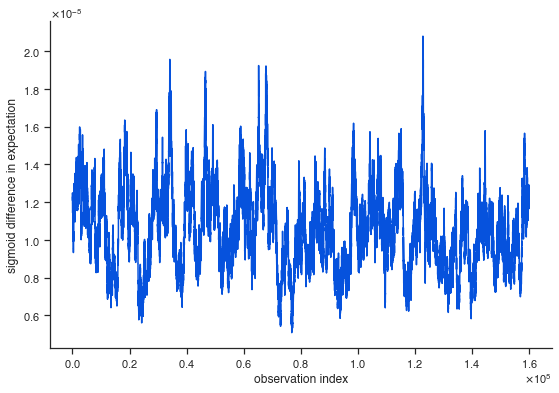

In [179]:
dvm_plot.trace_plot(long_rwm_run)

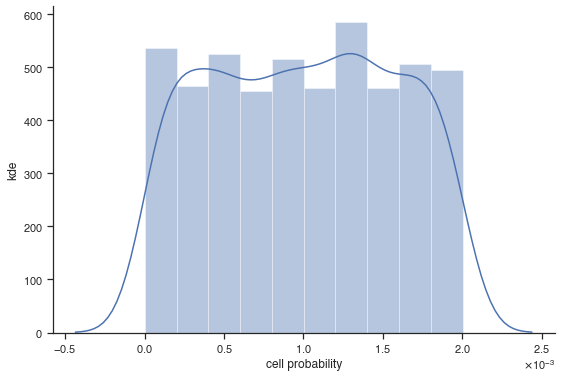

In [180]:
dvm_plot.phc_plot_flat(test_phc)

In [187]:
test_phc_2d = phc.make_phc(2, 10)

In [183]:
test_demo_2d = {'Black': 10, 'white': 8}

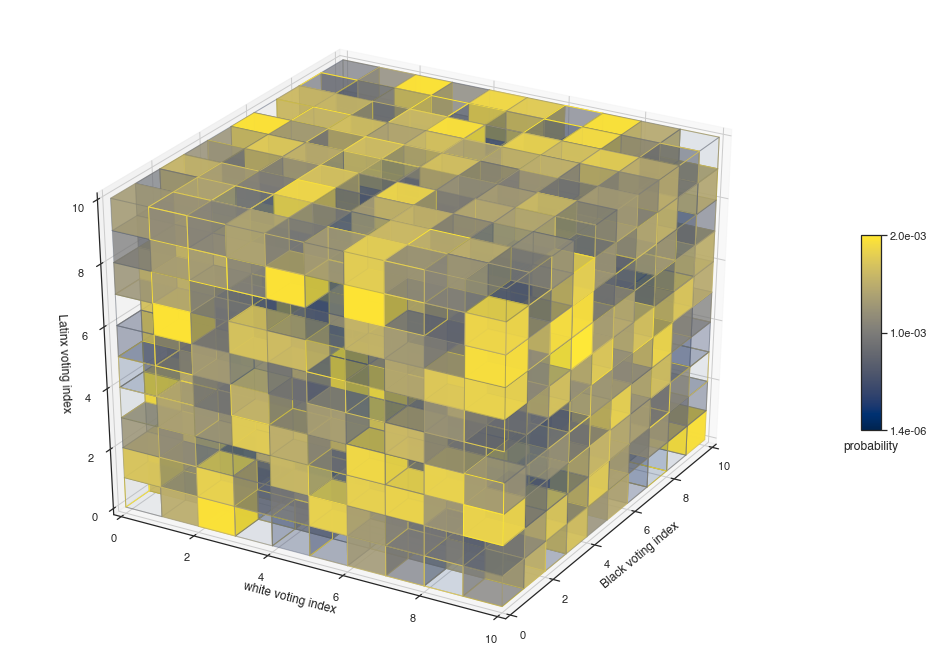

In [181]:
dvm_plot.phc_plot_3d(test_phc, demo=test_demo)

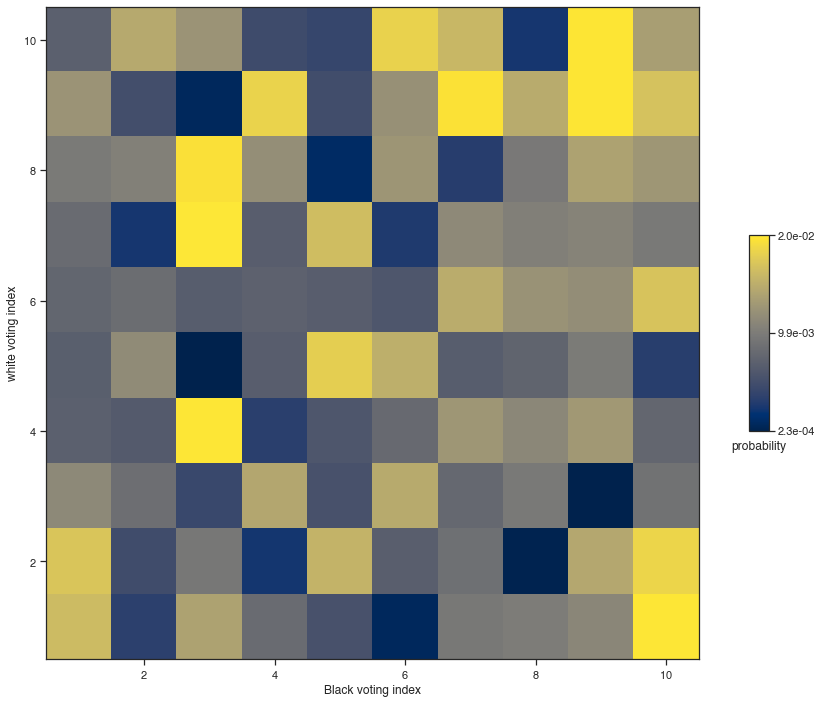

In [188]:
dvm_plot.phc_plot_2d(test_phc_2d, test_demo_2d, save=True)

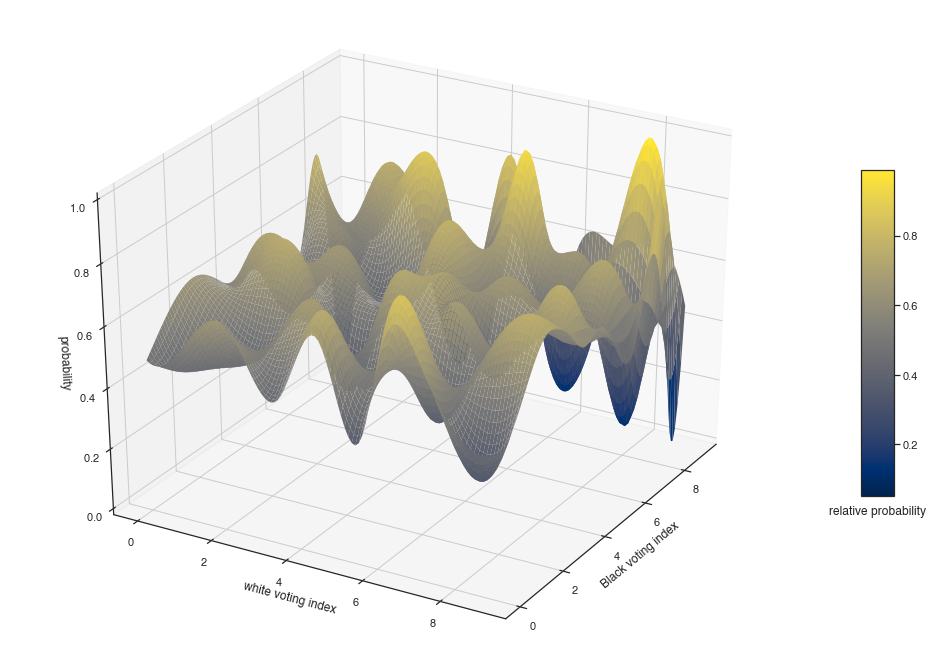

In [189]:
dvm_plot.phc_plot_2d_dist(phc.make_phc(2,10), test_demo_2d, save=True)

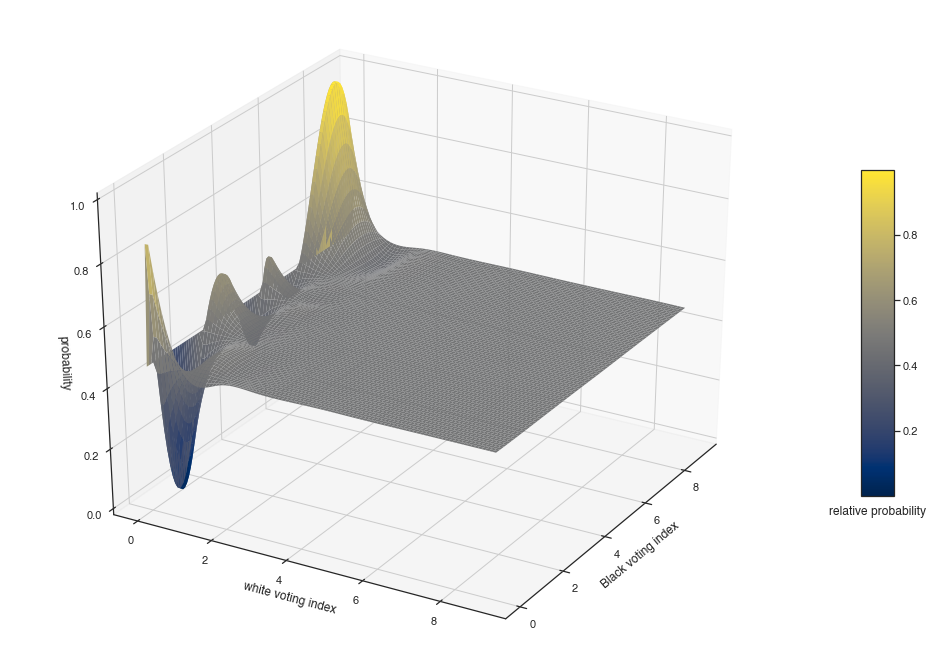

In [40]:
dvm_plot.phc_plot_2d_dist(test_phc_2d, test_demo_2d)

### `elect`

Make election objects.

In [18]:
test_dvp = {'Black': {'a': 0.4, 'b': 0.5, 'c': 0.1},
            'white': {'a': 0.3, 'b': 0.2, 'c': 0.5},
            'Latinx': {'a': 0.3, 'b': 0.5, 'c': 0.2}}

In [19]:
test_dvp_adv = {'C100': {'Black': {'a': 0.4, 'b': 0.5, 'c': 0.1},
            'white': {'a': 0.3, 'b': 0.2, 'c': 0.5},
            'Latinx': {'a': 0.3, 'b': 0.5, 'c': 0.2}},
               'C200': {'Black': {'a': 0.4, 'b': 0.5, 'c': 0.1},
            'white': {'a': 0.3, 'b': 0.2, 'c': 0.5},
            'Latinx': {'a': 0.3, 'b': 0.5, 'c': 0.2}}}

In [20]:
test_dvp_2d = {'Black': {'a': 0.4, 'b': 0.6},
              'white': {'a': 0.8, 'b': 0.2}}

In [21]:
test_candidates = ['a', 'b', 'c']

In [22]:
test_cand_2d = ['a', 'b']

In [25]:
te = elect.Election(test_candidates, test_demo_adv, demo_vote_prob=test_dvp_adv)

In [26]:
te.dvp

{'C100': {'Black': {'a': 0.4, 'b': 0.5, 'c': 0.1},
  'white': {'a': 0.3, 'b': 0.2, 'c': 0.5},
  'Latinx': {'a': 0.3, 'b': 0.5, 'c': 0.2}},
 'C200': {'Black': {'a': 0.4, 'b': 0.5, 'c': 0.1},
  'white': {'a': 0.3, 'b': 0.2, 'c': 0.5},
  'Latinx': {'a': 0.3, 'b': 0.5, 'c': 0.2}}}

In [27]:
te.winner

'b'

In [29]:
te

A mock election with 3 candidates in a district with 2 precincts and 3 demographic groups.

In [32]:
te.outcome

{'C100': {'a': (9, {'Black': 3, 'white': 4, 'Latinx': 2}),
  'b': (11, {'Black': 5, 'white': 3, 'Latinx': 3}),
  'c': (3, {'Black': 2, 'white': 1, 'Latinx': 0})},
 'C200': {'a': (10, {'Black': 2, 'white': 4, 'Latinx': 4}),
  'b': (13, {'Black': 2, 'white': 2, 'Latinx': 9}),
  'c': (5, {'Black': 1, 'white': 2, 'Latinx': 2})}}

In [51]:
te.get_demo_votes('a')

{'Black': 3, 'white': 3, 'Latinx': 2}

In [53]:
real_election = elect.Election(test_candidates, test_demo, test_dvp, mock=False)

In [54]:
real_election

A real election with 3 candidates in a district with 3 demographic groups.

### King's Ecological Inference

In [57]:
test_prec_demos = [test_demo_2d for x in range(4)]
test_first_cand_obs_votes = np.array([7, 4, 10, 15])

In [58]:
test_prec_demos

[{'Black': 10, 'white': 8},
 {'Black': 10, 'white': 8},
 {'Black': 10, 'white': 8},
 {'Black': 10, 'white': 8}]

In [59]:
kei.eco_inf(test_prec_demos, test_first_cand_obs_votes)

In [63]:
test_model = kei.eco_inf(test_prec_demos, test_first_cand_obs_votes)

with test_model:
    test_trace = pm.sample()

Sampling 4 chains, 44 divergences: 100%|██████████| 4000/4000 [00:05<00:00, 747.73draws/s]


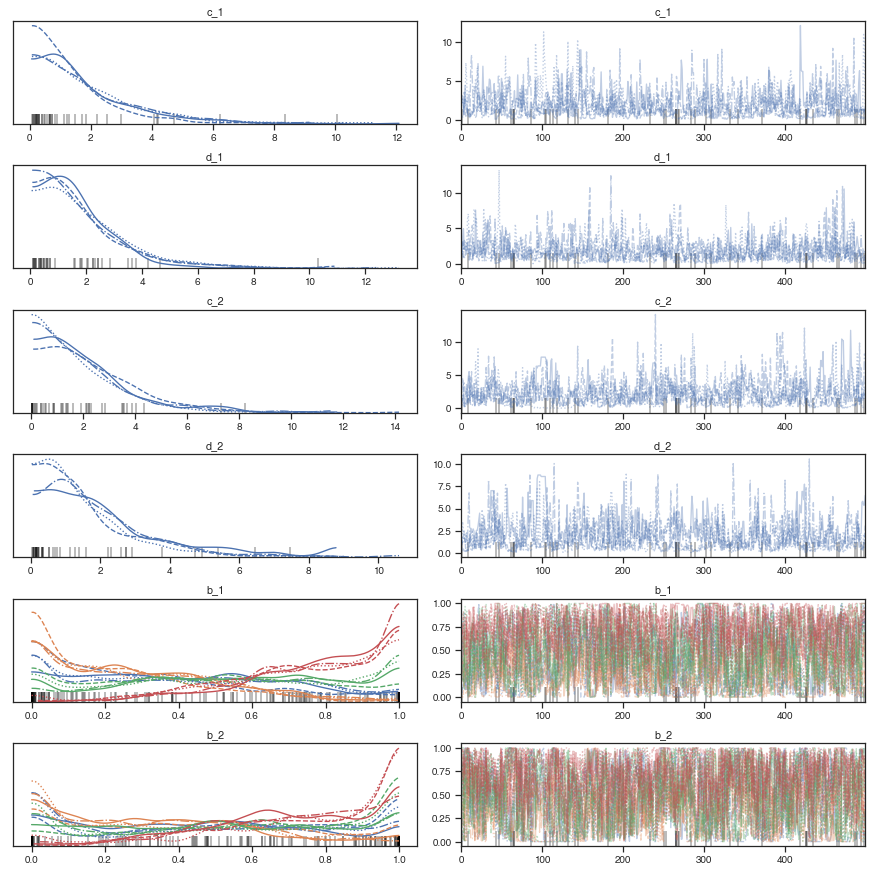

In [64]:
# Plot the traces
pm.traceplot(test_trace);

In [65]:
print(f"b_1 mean across districts: {str(test_trace.get_values('b_1').mean())}")

pm.stats.summary(test_trace, var_names=['b_1', 'b_2'])

b_1 mean across districts: 0.48167733848650574


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b_1[0],0.391,0.277,0.000,0.852,0.017,0.012,261.0,261.0,265.0,437.0,1.02
b_1[1],0.273,0.227,0.000,0.674,0.013,0.009,309.0,309.0,209.0,143.0,1.03
b_1[2],0.520,0.295,0.028,1.000,0.016,0.012,328.0,328.0,264.0,222.0,1.02
b_1[3],0.741,0.210,0.365,1.000,0.010,0.007,439.0,407.0,326.0,314.0,1.02
b_2[0],0.476,0.320,0.000,0.973,0.021,0.015,228.0,228.0,157.0,74.0,1.03
b_2[1],0.371,0.279,0.000,0.872,0.017,0.012,272.0,272.0,185.0,128.0,1.03
b_2[2],0.540,0.317,0.022,1.000,0.020,0.014,252.0,252.0,163.0,91.0,1.03
b_2[3],0.706,0.241,0.278,1.000,0.011,0.008,442.0,442.0,392.0,467.0,1.01


### Evaluation

In [66]:
dvm_eval.dvm_evaluator(te, 'test', expec_scoring=True, n_steps=200, n_iter=2)

The Random Walk Metropolis chain will be run in 20 chunks of size 10, with 0 steps at the end.

[1/3] Running the chain on 20 chunks of 10 iterations each...



[2/3] Running the chain for 0 more steps...
[3/3] Burning 0.3 of the sample...
Done.
Generated a sample of 140 observations in ~17 seconds.
The Random Walk Metropolis chain will be run in 20 chunks of size 10, with 0 steps at the end.

[1/3] Running the chain on 20 chunks of 10 iterations each...



[2/3] Running the chain for 0 more steps...
[3/3] Burning 0.3 of the sample...
Done.
Generated a sample of 140 observations in ~19 seconds.



{'label': 'test',
 'time': 18.239779114723206,
 'mle_phc_mse': 0.15916667206833784,
 'mean_phc_mse': 0.15916667206833784}

In [70]:
dvm_eval.dvm_evaluator(te, 'test', hmc=True, expec_scoring=True, n_steps=200, n_iter=2)

This Hamiltonian Monte Carlo chain will be run in 16 chunks of size 10, with 36 steps of adaptation and 4 steps at the end.

[1/3] Running the chain for 36 steps to adapt the step size...
[2/3] Running the chain with a step size of 0.037341464310884476 on 16 chunks of 10 iterations each...



[3/3] Running the chain for 4 more steps...
[4/3] Burning 0.3 of samples...
Done.
Generated a sample of 140 observations in ~91 seconds.
This Hamiltonian Monte Carlo chain will be run in 16 chunks of size 10, with 36 steps of adaptation and 4 steps at the end.

[1/3] Running the chain for 36 steps to adapt the step size...
[2/3] Running the chain with a step size of 0.033804744482040405 on 16 chunks of 10 iterations each...



[3/3] Running the chain for 4 more steps...
[4/3] Burning 0.3 of samples...
Done.
Generated a sample of 140 observations in ~92 seconds.



{'label': 'test',
 'time': 91.80015361309052,
 'mle_phc_mse': 0.11583333486070249,
 'mean_phc_mse': 0.08249999711910892}

In [68]:
dvm_eval.dvm_evaluator(te_2d, 'test', expec_scoring=True, n_steps=200, n_iter=2)

The Random Walk Metropolis chain will be run in 20 chunks of size 10, with 0 steps at the end.

[1/3] Running the chain on 20 chunks of 10 iterations each...



[2/3] Running the chain for 0 more steps...
[3/3] Burning 0.3 of the sample...
Done.
Generated a sample of 140 observations in ~3 seconds.
The Random Walk Metropolis chain will be run in 20 chunks of size 10, with 0 steps at the end.

[1/3] Running the chain on 20 chunks of 10 iterations each...



[2/3] Running the chain for 0 more steps...
[3/3] Burning 0.3 of the sample...
Done.
Generated a sample of 140 observations in ~2 seconds.



{'label': 'test',
 'time': 2.9697444438934326,
 'mle_phc_mse': 0.11250000149011631,
 'mean_phc_mse': 0.12749999940395362}

In [67]:
dvm_eval.kei_evaluator(te_2d, 'test')

{'label': 'test', 'time': 10.96445107460022, 'mse': 0.05568513606444232}